# How to do an ensemble model for time series forecasting

Ensemble learning is a very promising technique for time series forecasting. The purpose of ensemble learning is to combine several simple models into a single strong learner to reduce errors or improve forecasting results.

StatsForecast allows you to create ensembles models in a very easy way. First we need to import the data that we are going to use, in this case the M4 Dataset. After that, we´ll generate the forecasts via the `generate_forecast()` function. Finally, we´ll create the ensemble models using the forecasts generated. In this notebook we’ll implement and benchmark a ensemble model of AutoARIMA, AutoETS, AutoCES and AutoTheta:

+ AutoARIMA: The autoregressive integrated moving average (ARIMA), combines differencing steps, lag regression and moving averages into a single method capable of modeling non-stationary time series. This method complements on ETS and it is based on the description of data’s autocorrelations.

+ ETS: The exponential smoothing (ETS) algorithm is especially suited for data with seasonality and trend. ETS computes a weighted average over all observations in the input time series dataset as its prediction. In contrast to moving average methods with constant weights, ETS weights exponentially decrease over time, capturing long term dependencies while prioritizing new observations.

+ CES algorithm models the time series using “information potential”, modeling the non-linearity in time series using a complex-valued representation. The weights exponentially decrease over time on complex and real plains rather than the constant weights in simple moving average methods.

+ AutoTheta: The Theta method is generalized for automatic forecasting by introducing three extensions on its framework to boost its performance. This includes (i) considering both linear and non-linear trends, (ii) allowing to adjust the slope of such trends, and (iii) introducing a multiplicative expression of the underlying forecasting model along with the existing, additive one.

### Import the libraries that we are going to use for the analysis:

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np
import scipy

# Plotting graphs
import matplotlib.pyplot as plt

# Statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ETS, AutoCES, AutoTheta, Naive
from neuralforecast.data.datasets.m4 import M4, M4Info

# Others
from datasetsforecast.utils import Info, async_download_files, download_file, extract_file
from datasetsforecast.losses import mase, smape
from fastcore.test import test_close
from typing import Optional, Tuple, Union
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import random
import fire
import os

c:\Users\Facundo Allia\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Loading and Exploring the M4 Dataset

The M4 dataset is a collection of 100,000 time series used for the fourth edition of the Makridakis forecasting Competition. The M4 dataset consists of time series of yearly, quarterly, monthly and other (weekly, daily and hourly) data, which are divided into training and test sets:

| Frequency | Freq. Domain | Min # observations training set | Forecasting horizon |
|-----------|--------------|---------------------------------|---------------------|
| Yearly    | 23000        | 13                              | 6                   |
| Quarterly | 24000        | 16                              | 8                   |
| Monthly   | 48000        | 42                              | 18                  |
| Weekly    | 359          | 80                              | 13                  |
| Daily     | 4227         | 93                              | 14                  |
| Hourly    | 414          | 700                             | 48                  |


In [9]:
# Create a dictionary with the data:
dict_datasets = {'M4': (M4, M4Info)}

In [22]:
def generate_forecast(directory: str, dataset, group):

    '''generate_forecast() function: Return a dataframe with AutoARIMA, ETS, CES and AutoTheta forecasts for the group required.

    * df_forecast: 'data'
    * dataset: 'M4'
    * group: Refeers to the M4 group (Hourly, Daily, Weekly, Monthly, Quarterly or Yearly)'''

    dataclass, datainfo = dict_datasets[dataset]
    Y_df_group, *_ = dataclass.load(directory, group)
    
    ids = list(Y_df_group['unique_id'].unique())
    Y_df = Y_df_group.query('unique_id in @ids')
    Y_df["unique_id"] = Y_df["unique_id"].astype(str)

    # Set the forecast horizon and frecuency:
    horizon = datainfo[group].horizon
    freq = datainfo[group].freq
    seasonality = datainfo[group].seasonality

    # Split data in train and test series:
    Y_df_test = Y_df.groupby('unique_id').tail(horizon)
    Y_train_df = Y_df.drop(Y_df_test.index)

    # Define the models that are going to compose the ensemble:
    models = [AutoARIMA(season_length=seasonality, approximation=True),
              ETS(season_length=seasonality, model='ZZA'), 
              AutoCES(season_length=seasonality),
              AutoTheta(season_length=seasonality)]

    # Create the forecast object and forecast test set:
    model = StatsForecast(df=Y_train_df, models=models, freq=freq, n_jobs=-1, fallback_model= Naive())
    Y_hat_df = model.forecast(horizon).reset_index()


    Y_test_df = Y_df_test.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

    return Y_test_df

In [4]:
def get_train_df(group: str):

    '''get_train_df() function: Return a dataframe with train values for the group required.

    * group: Refeers to the M4 group (Hourly, Daily, Weekly, Monthly, Quarterly or Yearly)'''

    dataclass, datainfo = dict_datasets['M4']
    Y_df_total, *_ = dataclass.load('data2', group)
    seasonality = datainfo[group].seasonality
    Y_train_df = Y_df_total.drop(Y_df_total.groupby('unique_id').tail(seasonality).index)
    
    return Y_train_df

In [5]:
# Plot functions:
def plot_grid(df_train, model_cols=["y_50"], df_test=None, plot_random=True):

    '''Plots multiple time series.'''

    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train', c='black')
        axes[idx, idy].xaxis.set_tick_params(rotation=45)
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            axes[idx, idy].plot(test_uid['ds'], test_uid['y'], c='black', label='True')

            for col in model_cols:
                axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col)

        axes[idx, idy].set_title(f'State: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.7)
    plt.show()

In [6]:
#| export
class M4Evaluation:
    
    @staticmethod
    def load_benchmark(directory: str, group: str,
                       source_url: Optional[str] = None) -> np.ndarray:
                       
        '''Downloads and loads a bechmark forecasts.
        
        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'Yearly', 'Quarterly', 'Monthly', 
                            'Weekly', 'Daily', 'Hourly'.
        source_url: str, optional
            Optional benchmark url obtained from 
            https://github.com/Nixtla/m4-forecasts/tree/master/forecasts.
            If `None` returns Naive2. 
        
        Returns
        -------
        benchmark: numpy array
            Numpy array of shape (n_series, horizon).
        '''

        path = f'{directory}/m4/datasets'
        initial = group[0]
        if source_url is not None:
            filename = source_url.split('/')[-1].replace('.rar', '.csv')
            filepath = f'{path}/{filename}'
            if not os.path.exists(filepath):
                download_file(path, source_url, decompress=True)
        else:
            filepath = f'{path}/submission-Naive2.csv'
        
        benchmark = pd.read_csv(filepath)
        benchmark = benchmark[benchmark['id'].str.startswith(initial)]
        benchmark = benchmark.set_index('id').dropna(axis=1)
        benchmark = benchmark.sort_values('id').values
        
        return benchmark
    
    @staticmethod
    def evaluate(directory: str, group: str, 
                 y_hat: Union[np.ndarray, str]) -> pd.DataFrame:

        '''Evaluates y_hat according to M4 methodology.
        
        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'Yearly', 'Quarterly', 'Monthly', 
                            'Weekly', 'Daily', 'Hourly'.
        y_hat: numpy array, str
            Group forecasts as numpy array or
            benchmark url from
            https://github.com/Nixtla/m4-forecasts/tree/master/forecasts.
            
        Returns
        -------
        evaluation: pandas dataframe
            DataFrame with columns OWA, SMAPE, MASE
            and group as index.
        '''

        if isinstance(y_hat, str):
            y_hat = M4Evaluation.load_benchmark(directory, group, y_hat)
        
        initial = group[0]
        class_group = M4Info[group]
        horizon = class_group.horizon
        seasonality = class_group.seasonality
        path = f'{directory}/m4/datasets'
        y_df, *_ = M4.load(directory, group)
        
        y_train = y_df.groupby('unique_id')['y'] 
        y_train = y_train.apply(lambda x: x.head(-horizon).values)
        y_train = y_train.values
        
        y_test = y_df.groupby('unique_id')['y']
        y_test = y_test.tail(horizon)
        y_test = y_test.values.reshape(-1, horizon)    

        naive2 = M4Evaluation.load_benchmark(directory, group)
        smape_y_hat = smape(y_test, y_hat)
        smape_naive2 = smape(y_test, naive2)
        
        mase_y_hat = np.mean([mase(y_test[i], y_hat[i], y_train[i], seasonality)
                              for i in range(class_group.n_ts)])
        mase_naive2 = np.mean([mase(y_test[i], naive2[i], y_train[i], seasonality)
                               for i in range(class_group.n_ts)])
        
        owa = .5 * (mase_y_hat / mase_naive2 + smape_y_hat / smape_naive2)
        
        evaluation = pd.DataFrame({'SMAPE': smape_y_hat,
                                   'MASE': mase_y_hat,
                                   'OWA': owa},
                                   index=[group])
        
        return evaluation

We'll now generate the forecasts and the ensemble for every frequency:

### Hourly time series forecast:

First, using the `generate_forecast()` function we create the forecasts for the frequency

In [ ]:
# Create forecasts:
hourly_df_forecast = generate_forecast('data', 'M4', 'Hourly')

Then, we create the ensemble forecast. We can create 2 diferents ensembles using mean and median of the basis models:

In [24]:
# Create Ensemble models:
hourly_df_forecast['Ensemble_median'] = hourly_df_forecast[['AutoARIMA', 'ETS', 'CES', 'AutoTheta']].median(axis=1)

# Export Pandas DataFrame to CSV:
hourly_df_forecast.to_csv('hourly_df_forecast.csv')

# Print dataframe:
hourly_df_forecast

,Unnamed: 0.1,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median,AutoTheta
0,0,0,H1,701,619.0,616.08417,631.88960,621.20000,829.844280,620.779535,620.359070
1,1,1,H1,702,565.0,544.43210,559.75085,556.26890,738.697553,555.954854,555.640808
2,2,2,H1,703,532.0,510.41450,519.23550,512.23285,684.207898,511.486847,510.740845
3,3,3,H1,704,495.0,481.04654,486.97336,479.32480,641.804587,480.185670,478.069061
4,4,4,H1,705,481.0,460.89307,464.69736,457.91028,613.447940,459.401675,456.843109
...,...,...,...,...,...,...,...,...,...,...,...
19867,19867,19867,H99,744,24039.0,26955.49600,26916.31000,26628.86700,35748.034229,26829.869844,26743.429688
19868,19868,19868,H99,745,22946.0,25947.76600,26036.80700,25965.55000,34630.097641,25956.658000,25940.169922
19869,19869,19869,H99,746,22217.0,25043.93000,25449.20000,25611.03500,33849.200182,25446.317773,25443.435547
19870,19870,19870,H99,747,21416.0,24461.45000,24974.53000,25202.98600,33210.494526,24983.523789,24992.517578


By plotting 8 random series we can see graphically the perfomance of the models created:

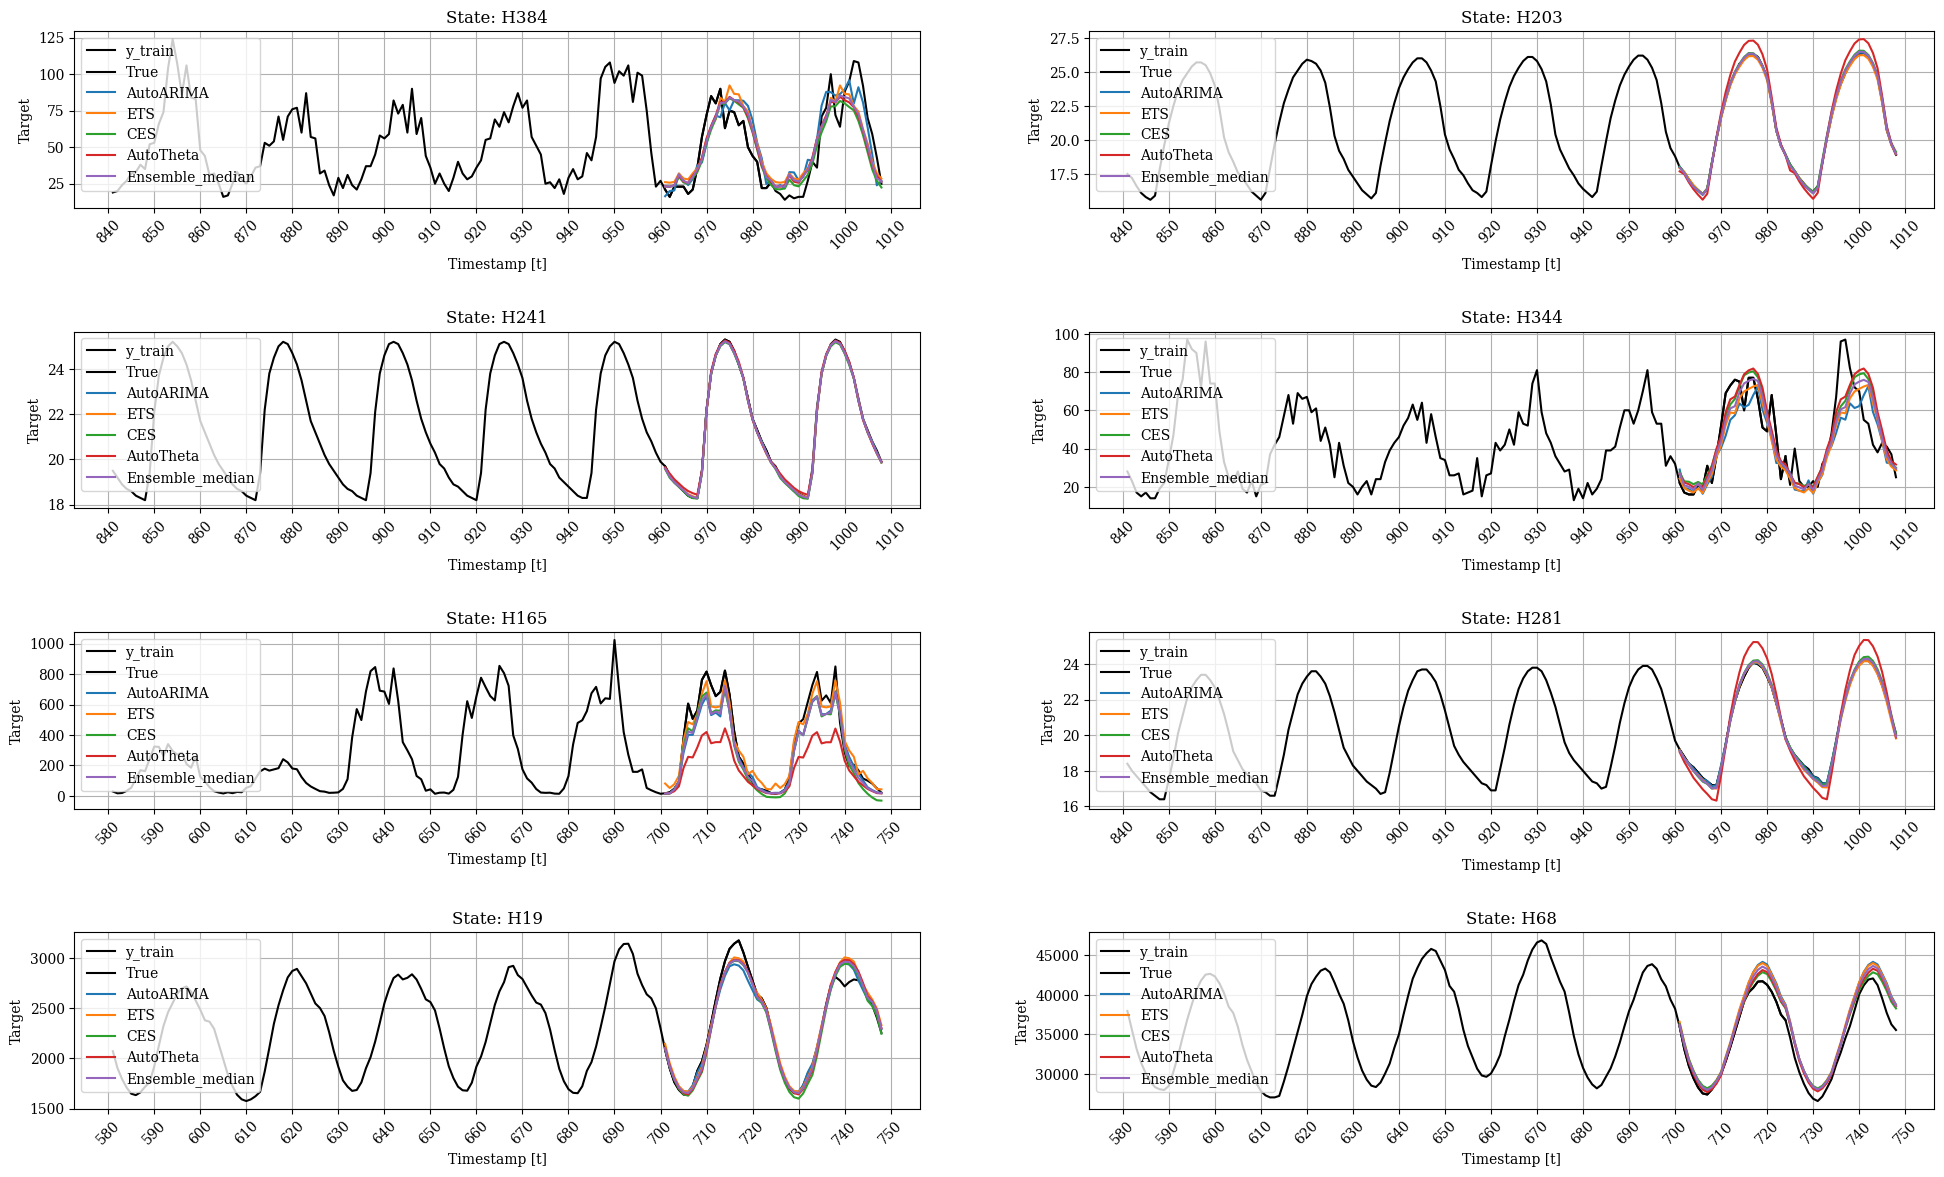

In [61]:
# Get trarin dataframe:
df_train_hourly = get_train_df('Hourly')

# Plot a random sample of 8 series
plot_grid(df_train_hourly.groupby('unique_id').tail(3*48),
          model_cols=['AutoARIMA', 'ETS', 'CES','AutoTheta', 'Ensemble_median'], 
          df_test=hourly_df_forecast)

Finally, we can evaluate the models metrics using the function `M4Evaluation.evaluate()`. We need to provide a dataframe in horizontal format to this function, that why it´s necesary to make some format transformations:

In [28]:
#Evaluate models metrics:
df_fore_hformat_hourly = pd.read_csv('hourly_df_forecast.csv')

df_fore_hformat_hourly = df_fore_hformat_hourly.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_hourly['ds'] = df_fore_hformat_hourly.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_hourly: np.arange(1, len(df_fore_hformat_hourly) + 1))
df_fore_hformat_hourly = pd.melt(df_fore_hformat_hourly, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_hourly = pd.pivot(df_fore_hformat_hourly, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_hourly['model'] == 'Ensemble_median'
df_fore_hformat_hourly_ens = df_fore_hformat_hourly[df_mask]

df_fore_hformat_hourly_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_hourly_ens = df_fore_hformat_hourly_ens.set_index(df_fore_hformat_hourly_ens['id'])
df_fore_hformat_hourly_ens = df_fore_hformat_hourly_ens.drop(['id', 'model'], axis=1)

h_metrics_ens = M4Evaluation.evaluate('data2', 'Hourly', df_fore_hformat_hourly_ens.sort_values('id').values)

#AutoARIMA:
df_mask=df_fore_hformat_hourly['model'] == 'AutoARIMA'
df_fore_hformat_hourly_AutoARIMA = df_fore_hformat_hourly[df_mask]

df_fore_hformat_hourly_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_hourly_AutoARIMA = df_fore_hformat_hourly_AutoARIMA.set_index(df_fore_hformat_hourly_AutoARIMA['id'])
df_fore_hformat_hourly_AutoARIMA = df_fore_hformat_hourly_AutoARIMA.drop(['id', 'model'], axis=1)

h_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Hourly', df_fore_hformat_hourly_AutoARIMA.sort_values('id').values)

#ETS:
df_mask=df_fore_hformat_hourly['model'] == 'ETS'
df_fore_hformat_hourly_ETS = df_fore_hformat_hourly[df_mask]

df_fore_hformat_hourly_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_hourly_ETS = df_fore_hformat_hourly_ETS.set_index(df_fore_hformat_hourly_ETS['id'])
df_fore_hformat_hourly_ETS = df_fore_hformat_hourly_ETS.drop(['id', 'model'], axis=1)

h_metrics_ETS = M4Evaluation.evaluate('data2', 'Hourly', df_fore_hformat_hourly_ETS.sort_values('id').values)

#CES:
df_mask=df_fore_hformat_hourly['model'] == 'CES'
df_fore_hformat_hourly_CES = df_fore_hformat_hourly[df_mask]

df_fore_hformat_hourly_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_hourly_CES = df_fore_hformat_hourly_CES.set_index(df_fore_hformat_hourly_CES['id'])
df_fore_hformat_hourly_CES = df_fore_hformat_hourly_CES.drop(['id', 'model'], axis=1)

h_metrics_CES = M4Evaluation.evaluate('data2', 'Hourly', df_fore_hformat_hourly_CES.sort_values('id').values)

#AutoTheta
df_mask=df_fore_hformat_hourly['model'] == 'AutoTheta'
df_fore_hformat_hourly_AutoTheta = df_fore_hformat_hourly[df_mask]

df_fore_hformat_hourly_AutoTheta.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_hourly_AutoTheta = df_fore_hformat_hourly_AutoTheta.set_index(df_fore_hformat_hourly_AutoTheta['id'])
df_fore_hformat_hourly_AutoTheta = df_fore_hformat_hourly_AutoTheta.drop(['id', 'model'], axis=1)

h_metrics_AutoTheta = M4Evaluation.evaluate('data2', 'Hourly', df_fore_hformat_hourly_AutoTheta.sort_values('id').values)

# Total metrics:
metrics_hourly = [h_metrics_ens, h_metrics_AutoARIMA, h_metrics_ETS, h_metrics_CES, h_metrics_AutoTheta]  # List of dataframes
total_metrics_hourly = pd.concat(metrics_hourly)
total_metrics_hourly['model'] = ['Ensemble','AutoARIMA', 'ETS', 'CES', 'AutoTheta']
total_metrics_hourly

,SMAPE,MASE,OWA,model
Hourly,13.564690,1.013167,0.580463,Ensemble
Hourly,13.785071,1.060768,0.596394,AutoARIMA
Hourly,14.757317,1.065372,0.623800,ETS
Hourly,19.689685,1.183220,0.782559,CES
Hourly,18.158869,2.455882,1.006609,AutoTheta


We can repeat the process for the remaining frequencies:

### Daily time series forecast:


In [106]:
# Create forecasts:
daily_df_forecast = generate_forecast('data', 'M4', 'Daily')

In [49]:
# Create Ensemble models:
daily_df_forecast['Ensemble_median'] = daily_df_forecast[['AutoARIMA', 'ETS', 'CES', 'AutoTheta']].median(axis=1)

# Export Pandas DataFrame to CSV:
daily_df_forecast.to_csv('daily_df_forecast.csv')

# Print dataframe:
daily_df_forecast

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median,AutoTheta
0,0,0,0,D1,1007,2039.20,2029.7000,2030.0854,2031.1837,2707.233352,2030.408179,2030.730957
1,1,1,1,D1,1008,2035.00,2029.7000,2030.4905,2031.4049,2707.776388,2030.947700,2031.733765
2,2,2,2,D1,1009,2051.80,2029.7000,2031.5201,2033.0112,2708.989291,2032.128336,2032.736572
3,3,3,3,D1,1010,2061.80,2029.7000,2031.3804,2034.0948,2709.638193,2032.559890,2033.739380
4,4,4,4,D1,1011,2063.50,2029.7000,2031.5995,2035.7246,2710.588763,2033.170844,2034.742188
...,...,...,...,...,...,...,...,...,...,...,...,...
59173,59173,59173,59173,D999,1062,1262.08,1245.3746,1241.5011,1245.2219,1659.164695,1245.298250,1245.396484
59174,59174,59174,59174,D999,1063,1262.78,1245.3746,1243.5731,1247.0388,1660.462012,1245.387068,1245.399536
59175,59175,59175,59175,D999,1064,1264.66,1245.3746,1241.3363,1245.2800,1659.131244,1245.327300,1245.402832
59176,59176,59176,59176,D999,1065,1272.66,1245.3746,1244.5017,1248.6119,1661.298150,1245.390425,1245.406250


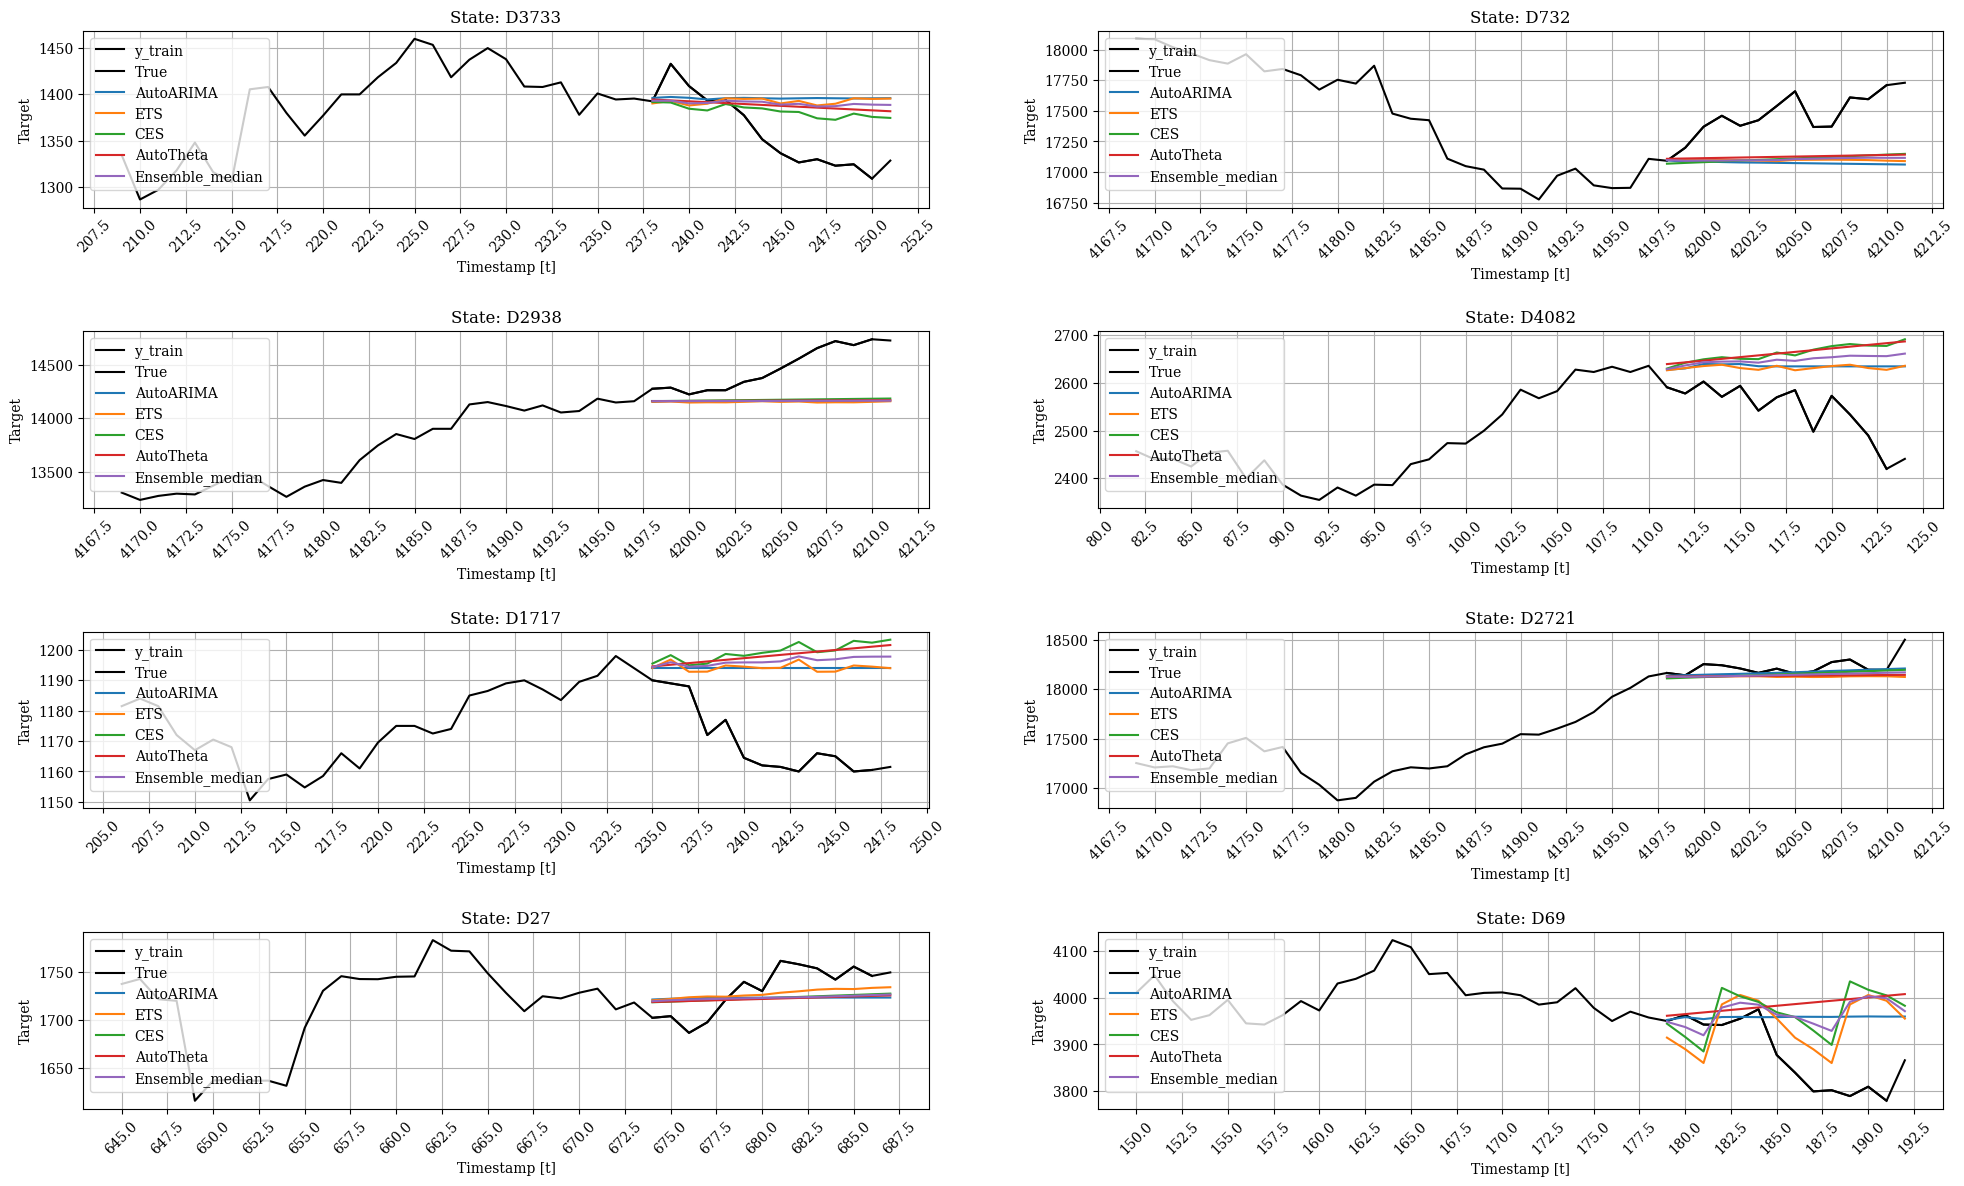

In [51]:
# Get trarin dataframe:
df_train_daily = get_train_df('Daily')

# Plot a random sample of 8 series:
plot_grid(df_train_daily.groupby('unique_id').tail(3*14), 
          model_cols=['AutoARIMA', 'ETS', 'CES', 'AutoTheta', 'Ensemble_median'], 
          df_test=daily_df_forecast)

In [33]:
#Evaluate models metrics:
df_fore_hformat_daily = pd.read_csv('daily_df_forecast.csv')

df_fore_hformat_daily = df_fore_hformat_daily.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_daily['ds'] = df_fore_hformat_daily.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_daily: np.arange(1, len(df_fore_hformat_daily) + 1))
df_fore_hformat_daily = pd.melt(df_fore_hformat_daily, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_daily = pd.pivot(df_fore_hformat_daily, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_daily['model'] == 'Ensemble_median'
df_fore_hformat_daily_ens = df_fore_hformat_daily[df_mask]

df_fore_hformat_daily_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_daily_ens = df_fore_hformat_daily_ens.set_index(df_fore_hformat_daily_ens['id'])
df_fore_hformat_daily_ens = df_fore_hformat_daily_ens.drop(['id', 'model'], axis=1)

d_metrics_ens = M4Evaluation.evaluate('data2', 'Daily', df_fore_hformat_daily_ens.sort_values('id').values)

#AutoARIMA
df_mask=df_fore_hformat_daily['model'] == 'AutoARIMA'
df_fore_hformat_daily_AutoARIMA = df_fore_hformat_daily[df_mask]

df_fore_hformat_daily_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_daily_AutoARIMA = df_fore_hformat_daily_AutoARIMA.set_index(df_fore_hformat_daily_AutoARIMA['id'])
df_fore_hformat_daily_AutoARIMA = df_fore_hformat_daily_AutoARIMA.drop(['id', 'model'], axis=1)

d_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Daily', df_fore_hformat_daily_AutoARIMA.sort_values('id').values)

#ETS
df_mask=df_fore_hformat_daily['model'] == 'ETS'
df_fore_hformat_daily_ETS = df_fore_hformat_daily[df_mask]

df_fore_hformat_daily_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_daily_ETS = df_fore_hformat_daily_ETS.set_index(df_fore_hformat_daily_ETS['id'])
df_fore_hformat_daily_ETS = df_fore_hformat_daily_ETS.drop(['id', 'model'], axis=1)

d_metrics_ETS = M4Evaluation.evaluate('data2', 'Daily', df_fore_hformat_daily_ETS.sort_values('id').values)

#CES
df_mask=df_fore_hformat_daily['model'] == 'CES'
df_fore_hformat_daily_CES = df_fore_hformat_daily[df_mask]

df_fore_hformat_daily_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_daily_CES = df_fore_hformat_daily_CES.set_index(df_fore_hformat_daily_CES['id'])
df_fore_hformat_daily_CES = df_fore_hformat_daily_CES.drop(['id', 'model'], axis=1)

d_metrics_CES = M4Evaluation.evaluate('data2', 'Daily', df_fore_hformat_daily_CES.sort_values('id').values)

#AutoTheta
df_mask=df_fore_hformat_daily['model'] == 'AutoTheta'
df_fore_hformat_daily_AutoTheta = df_fore_hformat_daily[df_mask]

df_fore_hformat_daily_AutoTheta.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_daily_AutoTheta = df_fore_hformat_daily_AutoTheta.set_index(df_fore_hformat_daily_AutoTheta['id'])
df_fore_hformat_daily_AutoTheta = df_fore_hformat_daily_AutoTheta.drop(['id', 'model'], axis=1)

d_metrics_AutoTheta = M4Evaluation.evaluate('data2', 'Daily', df_fore_hformat_daily_AutoTheta.sort_values('id').values)

# Total metrics:
metrics_daily = [d_metrics_ens, d_metrics_AutoARIMA, d_metrics_ETS, d_metrics_CES, d_metrics_AutoTheta]  # List of dataframes
total_metrics_daily = pd.concat(metrics_daily)
total_metrics_daily['model'] = ['Ensemble','AutoARIMA', 'ETS', 'CES', 'AutoTheta']
total_metrics_daily

,SMAPE,MASE,OWA,model
Daily,3.048131,3.254563,0.996834,Ensemble
Daily,3.147886,3.313655,1.022225,AutoARIMA
Daily,3.061928,3.291211,1.004688,ETS
Daily,3.129341,3.320487,1.020222,CES
Daily,3.050627,3.254627,0.997253,AutoTheta


### Weekly time series forecast:

In [111]:
# Create forecasts:
weekly_df_forecast = generate_forecast('data', 'M4', 'Weekly')

In [63]:
# Create Ensemble models:
weekly_df_forecast['Ensemble_median'] = weekly_df_forecast[['AutoARIMA', 'ETS', 'CES', 'AutoTheta']].median(axis=1)

# Export Pandas DataFrame to CSV:
weekly_df_forecast.to_csv('weekly_df_forecast.csv')

# Print dataframe:
weekly_df_forecast

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median,AutoTheta
0,0,0,0,W1,2180,35397.16,35342.890,35397.16,35612.797,47258.480250,35517.6955,35422.594
1,1,1,1,W1,2181,35808.59,34388.465,35397.16,35618.130,46946.654010,35527.1685,35436.207
2,2,2,2,W1,2182,35808.59,33750.640,35397.16,35617.050,46738.223437,35533.4350,35449.820
3,3,3,3,W1,2183,36246.14,33101.777,35397.16,35692.060,46551.476865,35577.7470,35463.434
4,4,4,4,W1,2184,36246.14,32489.988,35397.16,35727.113,46363.769292,35602.0800,35477.047
...,...,...,...,...,...,...,...,...,...,...,...,...
4662,4662,4662,4662,W99,2292,14864.72,15505.123,15101.03,15165.904,20309.941201,15161.8355,15157.767
4663,4663,4663,4663,W99,2293,14893.35,15499.500,15101.03,15163.030,20309.181458,15163.5070,15163.984
4664,4664,4664,4664,W99,2294,14811.60,15472.848,15101.03,15158.266,20300.782049,15164.2340,15170.202
4665,4665,4665,4665,W99,2295,14898.23,15484.617,15101.03,15195.575,20319.213974,15185.9975,15176.420


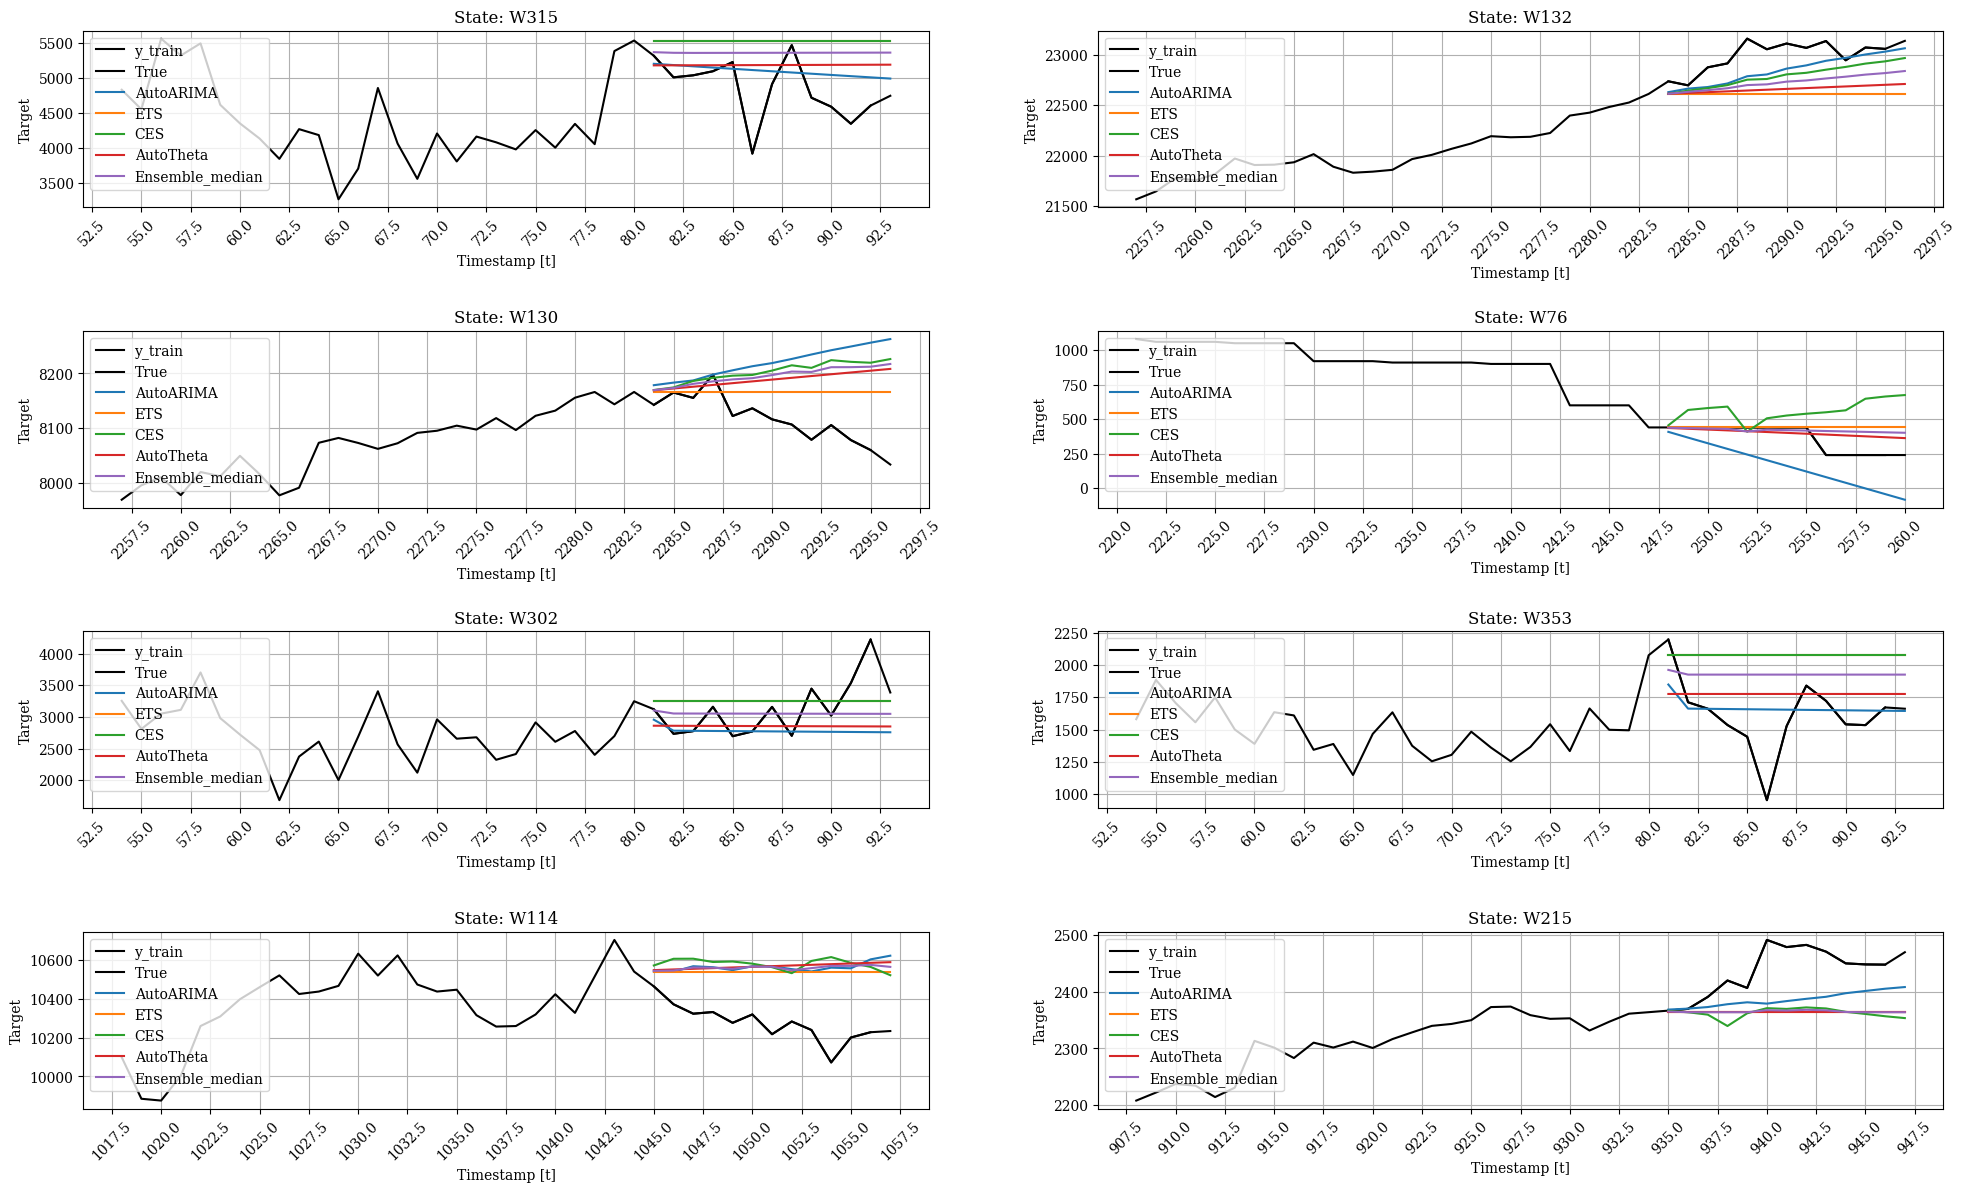

In [52]:
# Get trarin dataframe:
df_train_weekly = get_train_df('Weekly')

# Plot a random sample of 8 series:
plot_grid(df_train_weekly.groupby('unique_id').tail(3*13),
          model_cols=['AutoARIMA', 'ETS', 'CES', 'AutoTheta', 'Ensemble_median'], 
          df_test=weekly_df_forecast)

In [64]:
#Evaluate models metrics:
df_fore_hformat_weekly = pd.read_csv('weekly_df_forecast.csv')

df_fore_hformat_weekly = df_fore_hformat_weekly.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_weekly['ds'] = df_fore_hformat_weekly.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_weekly: np.arange(1, len(df_fore_hformat_weekly) + 1))
df_fore_hformat_weekly = pd.melt(df_fore_hformat_weekly, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_weekly = pd.pivot(df_fore_hformat_weekly, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_weekly['model'] == 'Ensemble_median'
df_fore_hformat_weekly_ens = df_fore_hformat_weekly[df_mask]

df_fore_hformat_weekly_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_weekly_ens = df_fore_hformat_weekly_ens.set_index(df_fore_hformat_weekly_ens['id'])
df_fore_hformat_weekly_ens = df_fore_hformat_weekly_ens.drop(['id', 'model'], axis=1)

w_metrics_ens = M4Evaluation.evaluate('data2', 'Weekly', df_fore_hformat_weekly_ens.sort_values('id').values)

#AutoARIMA
df_mask=df_fore_hformat_weekly['model'] == 'AutoARIMA'
df_fore_hformat_weekly_AutoARIMA = df_fore_hformat_weekly[df_mask]

df_fore_hformat_weekly_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_weekly_AutoARIMA = df_fore_hformat_weekly_AutoARIMA.set_index(df_fore_hformat_weekly_AutoARIMA['id'])
df_fore_hformat_weekly_AutoARIMA = df_fore_hformat_weekly_AutoARIMA.drop(['id', 'model'], axis=1)

w_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Weekly', df_fore_hformat_weekly_AutoARIMA.sort_values('id').values)

#ETS
df_mask=df_fore_hformat_weekly['model'] == 'ETS'
df_fore_hformat_weekly_ETS = df_fore_hformat_weekly[df_mask]

df_fore_hformat_weekly_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_weekly_ETS = df_fore_hformat_weekly_ETS.set_index(df_fore_hformat_weekly_ETS['id'])
df_fore_hformat_weekly_ETS = df_fore_hformat_weekly_ETS.drop(['id', 'model'], axis=1)

w_metrics_ETS = M4Evaluation.evaluate('data2', 'Weekly', df_fore_hformat_weekly_ETS.sort_values('id').values)

#CES
df_mask=df_fore_hformat_weekly['model'] == 'CES'
df_fore_hformat_weekly_CES = df_fore_hformat_weekly[df_mask]

df_fore_hformat_weekly_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_weekly_CES = df_fore_hformat_weekly_CES.set_index(df_fore_hformat_weekly_CES['id'])
df_fore_hformat_weekly_CES = df_fore_hformat_weekly_CES.drop(['id', 'model'], axis=1)

w_metrics_CES = M4Evaluation.evaluate('data2', 'Weekly', df_fore_hformat_weekly_CES.sort_values('id').values)

#AutoTheta
df_mask=df_fore_hformat_weekly['model'] == 'AutoTheta'
df_fore_hformat_weekly_AutoTheta = df_fore_hformat_weekly[df_mask]

df_fore_hformat_weekly_AutoTheta.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_weekly_AutoTheta = df_fore_hformat_weekly_AutoTheta.set_index(df_fore_hformat_weekly_AutoTheta['id'])
df_fore_hformat_weekly_AutoTheta = df_fore_hformat_weekly_AutoTheta.drop(['id', 'model'], axis=1)

w_metrics_AutoTheta = M4Evaluation.evaluate('data2', 'Weekly', df_fore_hformat_weekly_AutoTheta.sort_values('id').values)

# Total metrics:
metrics_weekly = [w_metrics_ens, w_metrics_AutoARIMA, w_metrics_ETS, w_metrics_CES, w_metrics_AutoTheta]  # List of dataframes
total_metrics_weekly = pd.concat(metrics_weekly)
total_metrics_weekly['model'] = ['Ensemble', 'AutoARIMA', 'ETS', 'CES', 'AutoTheta']
total_metrics_weekly

,SMAPE,MASE,OWA,model
Weekly,6.724892,2.219215,0.766556,Ensemble
Weekly,7.918108,2.674030,0.913559,AutoARIMA
Weekly,9.161287,2.777295,1.000000,ETS
Weekly,8.116045,2.352535,0.866483,CES
Weekly,9.183420,2.608353,0.970793,AutoTheta


### Monthly time series forecast:

In [ ]:
# Create forecasts:
monthly_df_forecast = generate_forecast('data', 'M4', 'Monthly')

In [74]:
# Create Ensemble models:
monthly_df_forecast['Ensemble_median'] = monthly_df_forecast[['AutoARIMA', 'ETS', 'CES', 'AutoTheta']].median(axis=1)

# Export Pandas DataFrame to CSV:
monthly_df_forecast.to_csv('monthly_df_forecast.csv')

# Print dataframe:
monthly_df_forecast

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median,AutoTheta
0,0,0,0,M1,470,8720.0,8951.7180,8408.3940,8511.9530,11018.557637,8460.17350,7183.6080
1,1,1,1,M1,471,7790.0,8672.3420,7553.3975,7647.7183,10330.048108,7600.55790,7116.6865
2,2,2,2,M1,472,4770.0,7298.8193,5874.9023,5973.6800,8442.672929,6077.14850,6180.6170
3,3,3,3,M1,473,5060.0,6906.7100,5539.8403,5628.4700,7962.055595,5719.80825,5811.1465
4,4,4,4,M1,474,4720.0,6446.5176,5032.9220,5007.5960,7316.583481,5247.81850,5462.7150
...,...,...,...,...,...,...,...,...,...,...,...,...
863995,863995,863995,863995,M9999,83,4200.0,3373.4060,4047.2908,2832.2737,4339.686781,3102.83985,2766.0898
863996,863996,863996,863996,M9999,84,4300.0,3367.4640,3774.5876,2754.7410,4184.345824,3061.10250,2656.2449
863997,863997,863997,863997,M9999,85,3800.0,3353.3690,3109.6357,2272.4970,3760.633867,2828.01785,2546.4000
863998,863998,863998,863998,M9999,86,4400.0,3357.4648,3268.4200,2580.5386,3880.992777,2924.47930,2436.5550


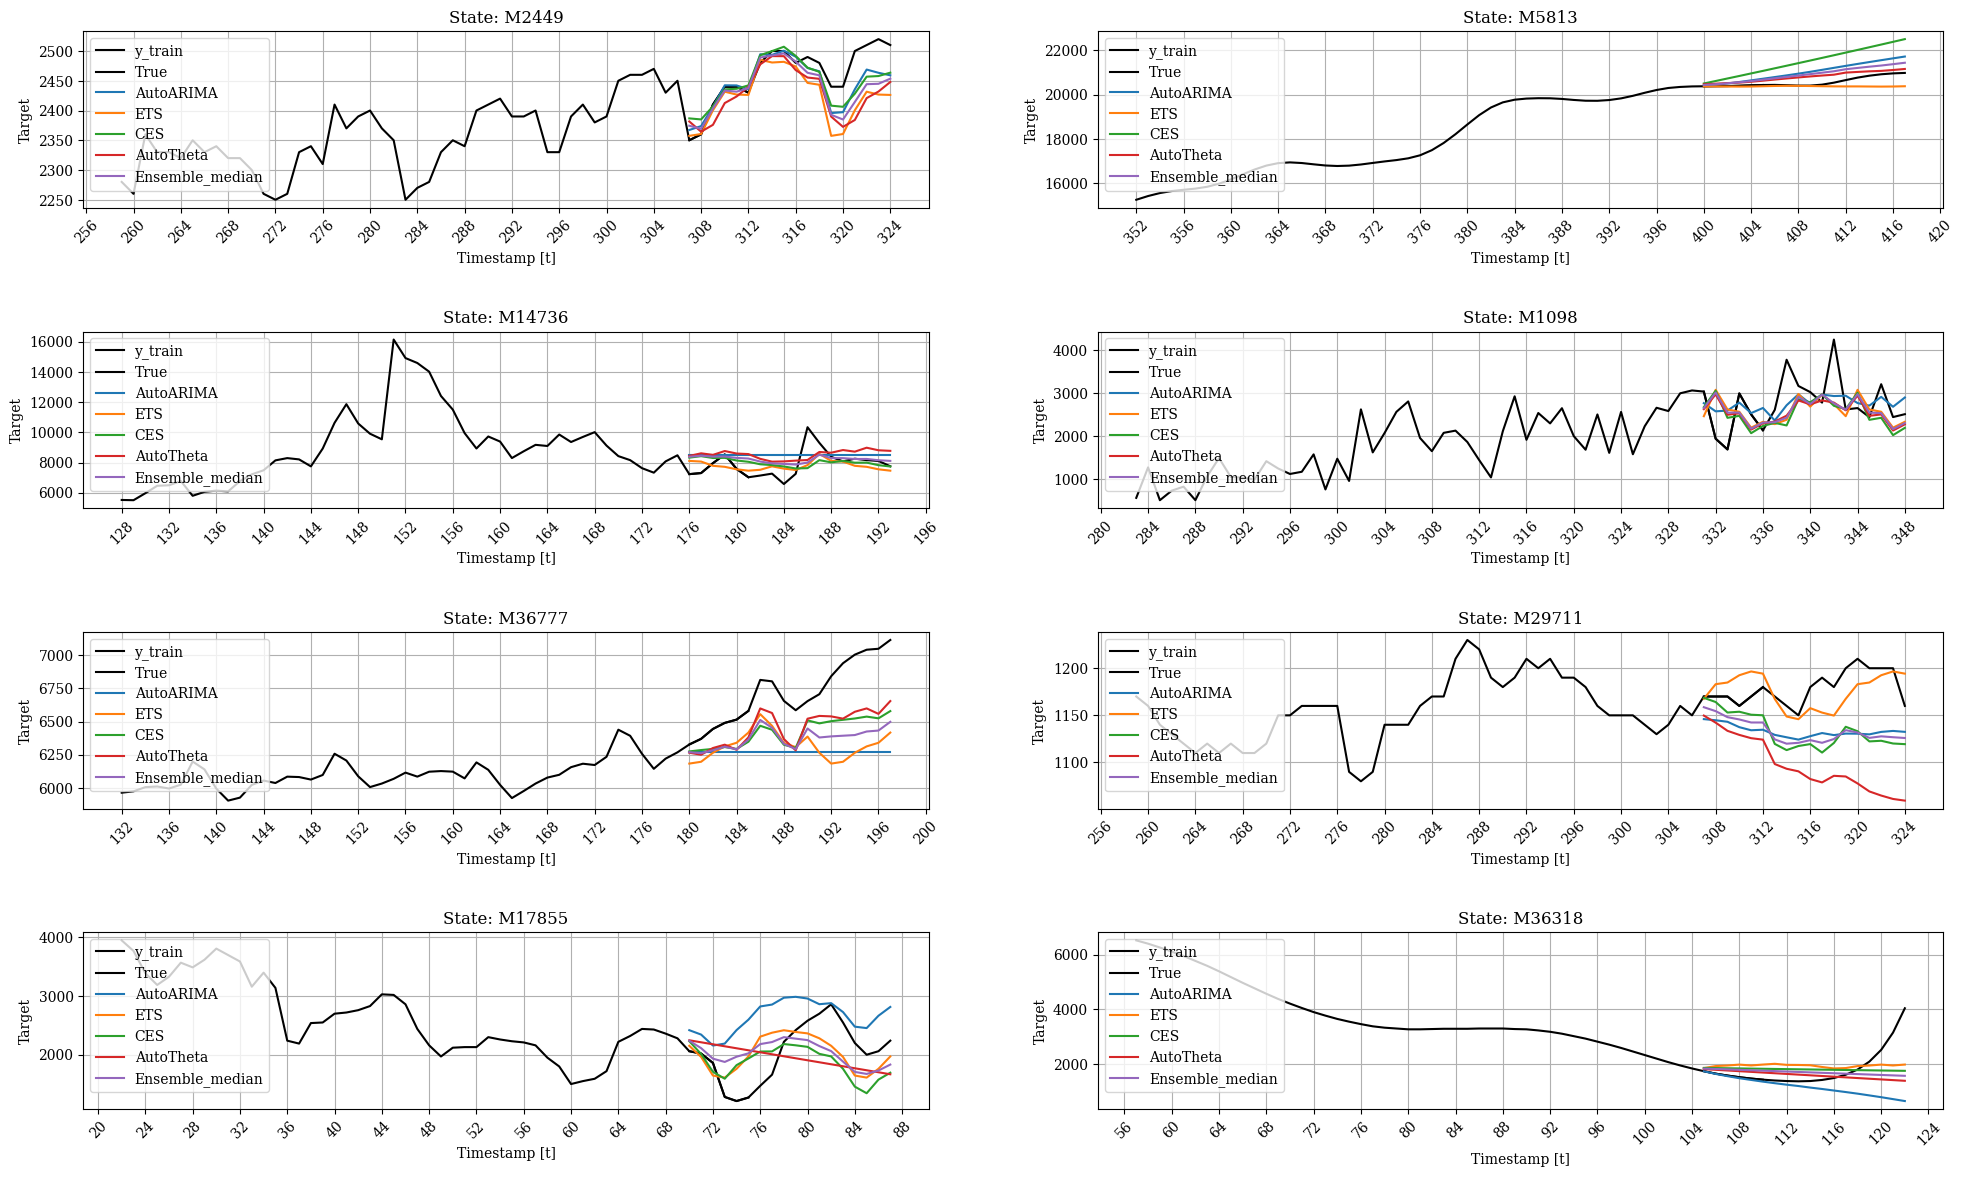

In [53]:
# Get trarin dataframe:
df_train_monthly = get_train_df('Monthly')

# Plot a random sample of 8 series:
plot_grid(df_train_monthly.groupby('unique_id').tail(3*18),
          model_cols=['AutoARIMA', 'ETS', 'CES', 'AutoTheta', 'Ensemble_median'], 
          df_test=monthly_df_forecast)

In [75]:
#Evaluate models metrics:
df_fore_hformat_monthly = pd.read_csv('monthly_df_forecast.csv')

df_fore_hformat_monthly = df_fore_hformat_monthly.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_monthly['ds'] = df_fore_hformat_monthly.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_monthly: np.arange(1, len(df_fore_hformat_monthly) + 1))
df_fore_hformat_monthly = pd.melt(df_fore_hformat_monthly, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_monthly = pd.pivot(df_fore_hformat_monthly, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_monthly['model'] == 'Ensemble_median'
df_fore_hformat_monthly_ens = df_fore_hformat_monthly[df_mask]

df_fore_hformat_monthly_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_monthly_ens = df_fore_hformat_monthly_ens.set_index(df_fore_hformat_monthly_ens['id'])
df_fore_hformat_monthly_ens = df_fore_hformat_monthly_ens.drop(['id', 'model'], axis=1)

m_metrics_ens = M4Evaluation.evaluate('data2', 'Monthly', df_fore_hformat_monthly_ens.sort_values('id').values)

#AutoARIMA
df_mask=df_fore_hformat_monthly['model'] == 'AutoARIMA'
df_fore_hformat_monthly_AutoARIMA = df_fore_hformat_monthly[df_mask]

df_fore_hformat_monthly_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_monthly_AutoARIMA = df_fore_hformat_monthly_AutoARIMA.set_index(df_fore_hformat_monthly_AutoARIMA['id'])
df_fore_hformat_monthly_AutoARIMA = df_fore_hformat_monthly_AutoARIMA.drop(['id', 'model'], axis=1)

m_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Monthly', df_fore_hformat_monthly_AutoARIMA.sort_values('id').values)

#ETS
df_mask=df_fore_hformat_monthly['model'] == 'ETS'
df_fore_hformat_monthly_ETS = df_fore_hformat_monthly[df_mask]

df_fore_hformat_monthly_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_monthly_ETS = df_fore_hformat_monthly_ETS.set_index(df_fore_hformat_monthly_ETS['id'])
df_fore_hformat_monthly_ETS = df_fore_hformat_monthly_ETS.drop(['id', 'model'], axis=1)

m_metrics_ETS = M4Evaluation.evaluate('data2', 'Monthly', df_fore_hformat_monthly_ETS.sort_values('id').values)

#CES
df_mask=df_fore_hformat_monthly['model'] == 'CES'
df_fore_hformat_monthly_CES = df_fore_hformat_monthly[df_mask]

df_fore_hformat_monthly_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_monthly_CES = df_fore_hformat_monthly_CES.set_index(df_fore_hformat_monthly_CES['id'])
df_fore_hformat_monthly_CES = df_fore_hformat_monthly_CES.drop(['id', 'model'], axis=1)

m_metrics_CES = M4Evaluation.evaluate('data2', 'Monthly', df_fore_hformat_monthly_CES.sort_values('id').values)

#AutoTheta
df_mask=df_fore_hformat_monthly['model'] == 'AutoTheta'
df_fore_hformat_monthly_AutoTheta = df_fore_hformat_monthly[df_mask]

df_fore_hformat_monthly_AutoTheta.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_monthly_AutoTheta = df_fore_hformat_monthly_AutoTheta.set_index(df_fore_hformat_monthly_AutoTheta['id'])
df_fore_hformat_monthly_AutoTheta = df_fore_hformat_monthly_AutoTheta.drop(['id', 'model'], axis=1)

m_metrics_AutoTheta = M4Evaluation.evaluate('data2', 'Monthly', df_fore_hformat_monthly_AutoTheta.sort_values('id').values)

# Total metrics:
metrics_monthly = [m_metrics_ens, m_metrics_AutoARIMA, m_metrics_ETS, m_metrics_CES, m_metrics_AutoTheta]  # List of dataframes
total_metrics_monthly = pd.concat(metrics_monthly)
total_metrics_monthly['model'] = [ 'Ensemble', 'AutoARIMA', 'ETS', 'CES', 'AutoTheta']
total_metrics_monthly

,SMAPE,MASE,OWA,model
Monthly,12.535877,0.908254,0.861532,Ensemble
Monthly,14.571859,1.083398,1.014449,AutoARIMA
Monthly,13.342081,0.955887,0.911871,ETS
Monthly,13.135264,0.935648,0.895186,CES
Monthly,13.212794,0.962291,0.910401,AutoTheta


### Quarterly time series forecast:

In [ ]:
# Create forecasts:
quarterly_df_forecast = generate_forecast('data', 'M4', 'Quarterly')

In [71]:
# Create Ensemble models:
quarterly_df_forecast['Ensemble_median'] = quarterly_df_forecast[['AutoARIMA', 'ETS', 'CES', 'AutoTheta']].median(axis=1)

# Export Pandas DataFrame to CSV:
quarterly_df_forecast.to_csv('quarterly_df_forecast.csv')

# Print dataframe:
quarterly_df_forecast

,Unnamed: 0.1,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median,AutoTheta
0,0,0,Q1,26,6790.643698,6794.0140,6948.3076,6931.5337,9132.150660,6862.773850,6722.596680
1,1,1,Q1,27,6598.952202,6837.6685,6779.1816,6738.2563,9013.753077,6758.718950,6686.152832
2,2,2,Q1,28,6608.527173,6837.6685,6876.0070,6817.9385,9060.440995,6827.803500,6649.708984
3,3,3,Q1,29,6765.914014,6837.6685,6790.4930,6694.1870,8978.537879,6742.340000,6613.265137
4,4,4,Q1,30,6992.949003,6837.6685,6948.3076,6843.3545,9068.717296,6840.511500,6576.821289
...,...,...,...,...,...,...,...,...,...,...,...
191995,191995,191995,Q9999,41,10490.000000,10469.7130,10730.2840,10998.3080,14326.742292,10756.102937,10781.921875
191996,191996,191996,Q9999,42,10558.000000,10490.3960,10871.3070,11193.9440,14510.275562,10923.243344,10975.179688
191997,191997,191997,Q9999,43,10832.000000,10506.5030,10987.5750,11406.7880,14667.424734,11044.491602,11101.408203
191998,191998,191998,Q9999,44,11226.000000,10519.0450,11068.7440,11614.7240,14787.052510,11113.694266,11158.644531


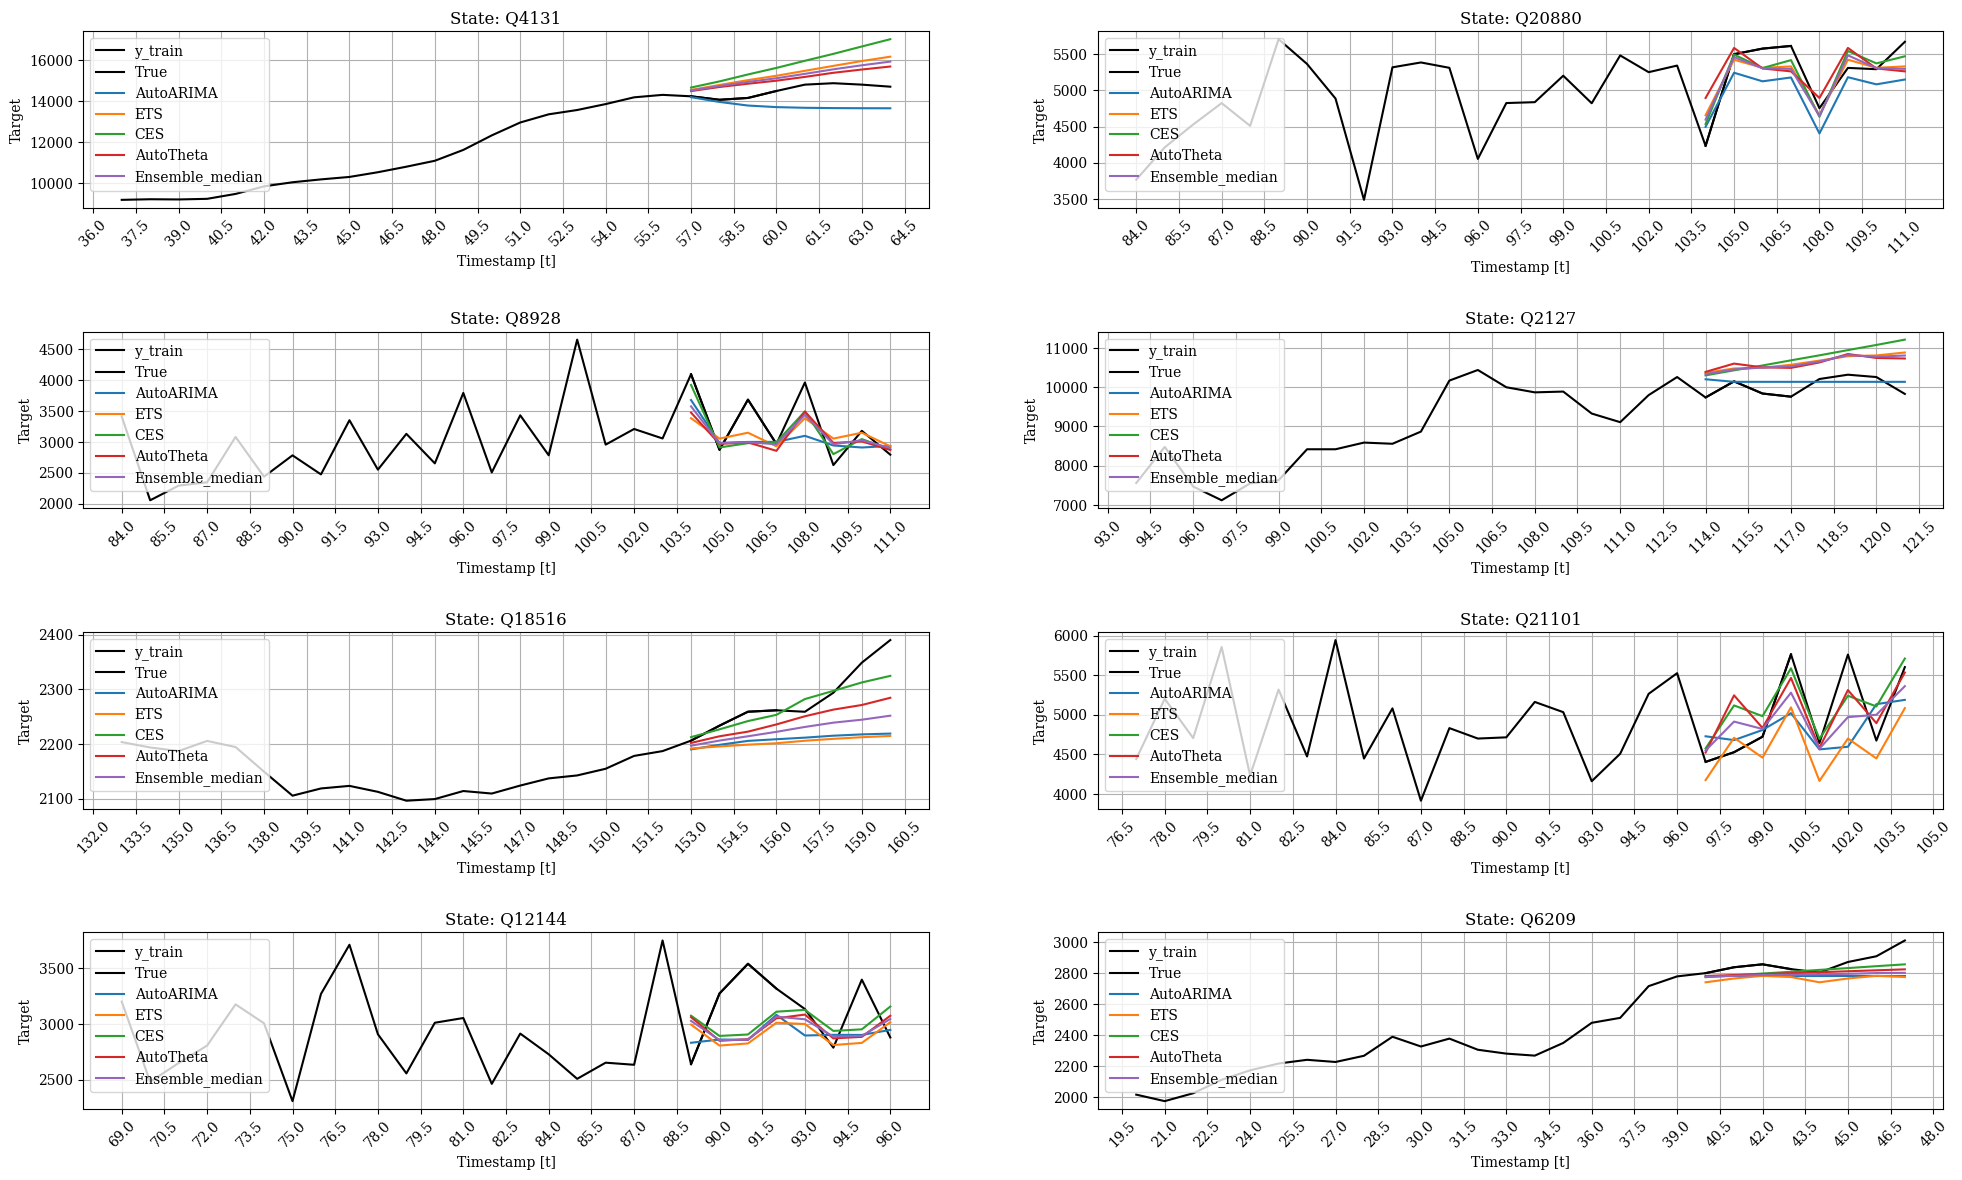

In [55]:
# Get trarin dataframe:
df_train_quarterly = get_train_df('Quarterly')

# Plot a random sample of 8 series:
plot_grid(df_train_quarterly.groupby('unique_id').tail(3*8),
          model_cols=['AutoARIMA', 'ETS', 'CES', 'AutoTheta', 'Ensemble_median'], 
          df_test=quarterly_df_forecast)

In [70]:
#Evaluate models metrics:
df_fore_hformat_quarterly = pd.read_csv('quarterly_df_forecast.csv')

df_fore_hformat_quarterly = df_fore_hformat_quarterly.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_quarterly['ds'] = df_fore_hformat_quarterly.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_quarterly: np.arange(1, len(df_fore_hformat_quarterly) + 1))
df_fore_hformat_quarterly = pd.melt(df_fore_hformat_quarterly, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_quarterly = pd.pivot(df_fore_hformat_quarterly, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_quarterly['model'] == 'Ensemble_median'
df_fore_hformat_quarterly_ens = df_fore_hformat_quarterly[df_mask]

df_fore_hformat_quarterly_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_quarterly_ens = df_fore_hformat_quarterly_ens.set_index(df_fore_hformat_quarterly_ens['id'])
df_fore_hformat_quarterly_ens = df_fore_hformat_quarterly_ens.drop(['id', 'model'], axis=1)

q_metrics_ens = M4Evaluation.evaluate('data2', 'Quarterly', df_fore_hformat_quarterly_ens.sort_values('id').values)

#AutoARIMA
df_mask=df_fore_hformat_quarterly['model'] == 'AutoARIMA'
df_fore_hformat_quarterly_AutoARIMA = df_fore_hformat_quarterly[df_mask]

df_fore_hformat_quarterly_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_quarterly_AutoARIMA = df_fore_hformat_quarterly_AutoARIMA.set_index(df_fore_hformat_quarterly_AutoARIMA['id'])
df_fore_hformat_quarterly_AutoARIMA = df_fore_hformat_quarterly_AutoARIMA.drop(['id', 'model'], axis=1)

q_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Quarterly', df_fore_hformat_quarterly_AutoARIMA.sort_values('id').values)

#ETS
df_mask=df_fore_hformat_quarterly['model'] == 'ETS'
df_fore_hformat_quarterly_ETS = df_fore_hformat_quarterly[df_mask]

df_fore_hformat_quarterly_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_quarterly_ETS = df_fore_hformat_quarterly_ETS.set_index(df_fore_hformat_quarterly_ETS['id'])
df_fore_hformat_quarterly_ETS = df_fore_hformat_quarterly_ETS.drop(['id', 'model'], axis=1)

q_metrics_ETS = M4Evaluation.evaluate('data2', 'Quarterly', df_fore_hformat_quarterly_ETS.sort_values('id').values)

#CES
df_mask=df_fore_hformat_quarterly['model'] == 'CES'
df_fore_hformat_quarterly_CES = df_fore_hformat_quarterly[df_mask]

df_fore_hformat_quarterly_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_quarterly_CES = df_fore_hformat_quarterly_CES.set_index(df_fore_hformat_quarterly_CES['id'])
df_fore_hformat_quarterly_CES = df_fore_hformat_quarterly_CES.drop(['id', 'model'], axis=1)

q_metrics_CES = M4Evaluation.evaluate('data2', 'Quarterly', df_fore_hformat_quarterly_CES.sort_values('id').values)

#AutoTheta
df_mask=df_fore_hformat_quarterly['model'] == 'AutoTheta'
df_fore_hformat_quarterly_AutoTheta = df_fore_hformat_quarterly[df_mask]

df_fore_hformat_quarterly_AutoTheta.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_quarterly_AutoTheta = df_fore_hformat_quarterly_AutoTheta.set_index(df_fore_hformat_quarterly_AutoTheta['id'])
df_fore_hformat_quarterly_AutoTheta = df_fore_hformat_quarterly_AutoTheta.drop(['id', 'model'], axis=1)

q_metrics_AutoTheta = M4Evaluation.evaluate('data2', 'Quarterly', df_fore_hformat_quarterly_AutoTheta.sort_values('id').values)

# Total metrics:
metrics_quarterly = [q_metrics_ens, q_metrics_AutoARIMA, q_metrics_ETS, q_metrics_CES, q_metrics_AutoTheta]  # List of dataframes
total_metrics_quarterly = pd.concat(metrics_quarterly)
total_metrics_quarterly['model'] = ['Ensemble', 'AutoARIMA', 'ETS', 'CES', 'AutoTheta']
total_metrics_quarterly

,SMAPE,MASE,OWA,model
Quarterly,10.111604,1.149934,0.878396,Ensemble
Quarterly,11.565041,1.398230,1.034920,AutoARIMA
Quarterly,10.367345,1.171166,0.897750,ETS
Quarterly,10.479131,1.183724,0.907404,CES
Quarterly,10.244733,1.182911,0.896465,AutoTheta


### Yearly time series forecast:

In [ ]:
# Create forecasts:
yearly_df_forecast = generate_forecast('data', 'M4', 'Yearly')

In [17]:
# Create Ensemble models:
yearly_df_forecast['Ensemble_median'] = yearly_df_forecast[['AutoARIMA', 'ETS', 'CES', 'AutoTheta']].median(axis=1)

# Export Pandas DataFrame to CSV:
yearly_df_forecast.to_csv('yearly_df_forecast.csv')

# Print dataframe:
yearly_df_forecast

,Unnamed: 0.1,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median,AutoTheta
0,0,0,Y1,32,7290.2,7094.7534,7261.1,7410.2900,9701.570912,7299.834668,7338.569336
1,1,1,Y1,33,7392.6,6992.0390,7261.1,7467.2593,9710.996536,7336.845654,7412.591309
2,2,2,Y1,34,7527.6,6928.6160,7261.1,7547.5386,9741.289294,7373.856641,7486.613281
3,3,3,Y1,35,7594.8,6889.4540,7261.1,7610.1370,9773.775418,7410.867627,7560.635254
4,4,4,Y1,36,7720.7,6865.2730,7261.1,7688.2440,9816.424742,7447.878613,7634.657227
...,...,...,...,...,...,...,...,...,...,...,...
137995,137995,137995,Y9999,26,10570.0,10630.6560,9517.0,10989.1690,13808.653255,10459.895383,10289.134766
137996,137996,137996,Y9999,27,11080.0,11187.4840,9517.0,11592.6490,14324.980206,10932.645809,10677.807617
137997,137997,137997,Y9999,28,12274.0,11744.3125,9517.0,12716.7740,15014.855656,11405.396484,11066.480469
137998,137998,137998,Y9999,29,13128.0,12301.1410,9517.0,13512.6830,15595.325773,11878.147160,11455.153320


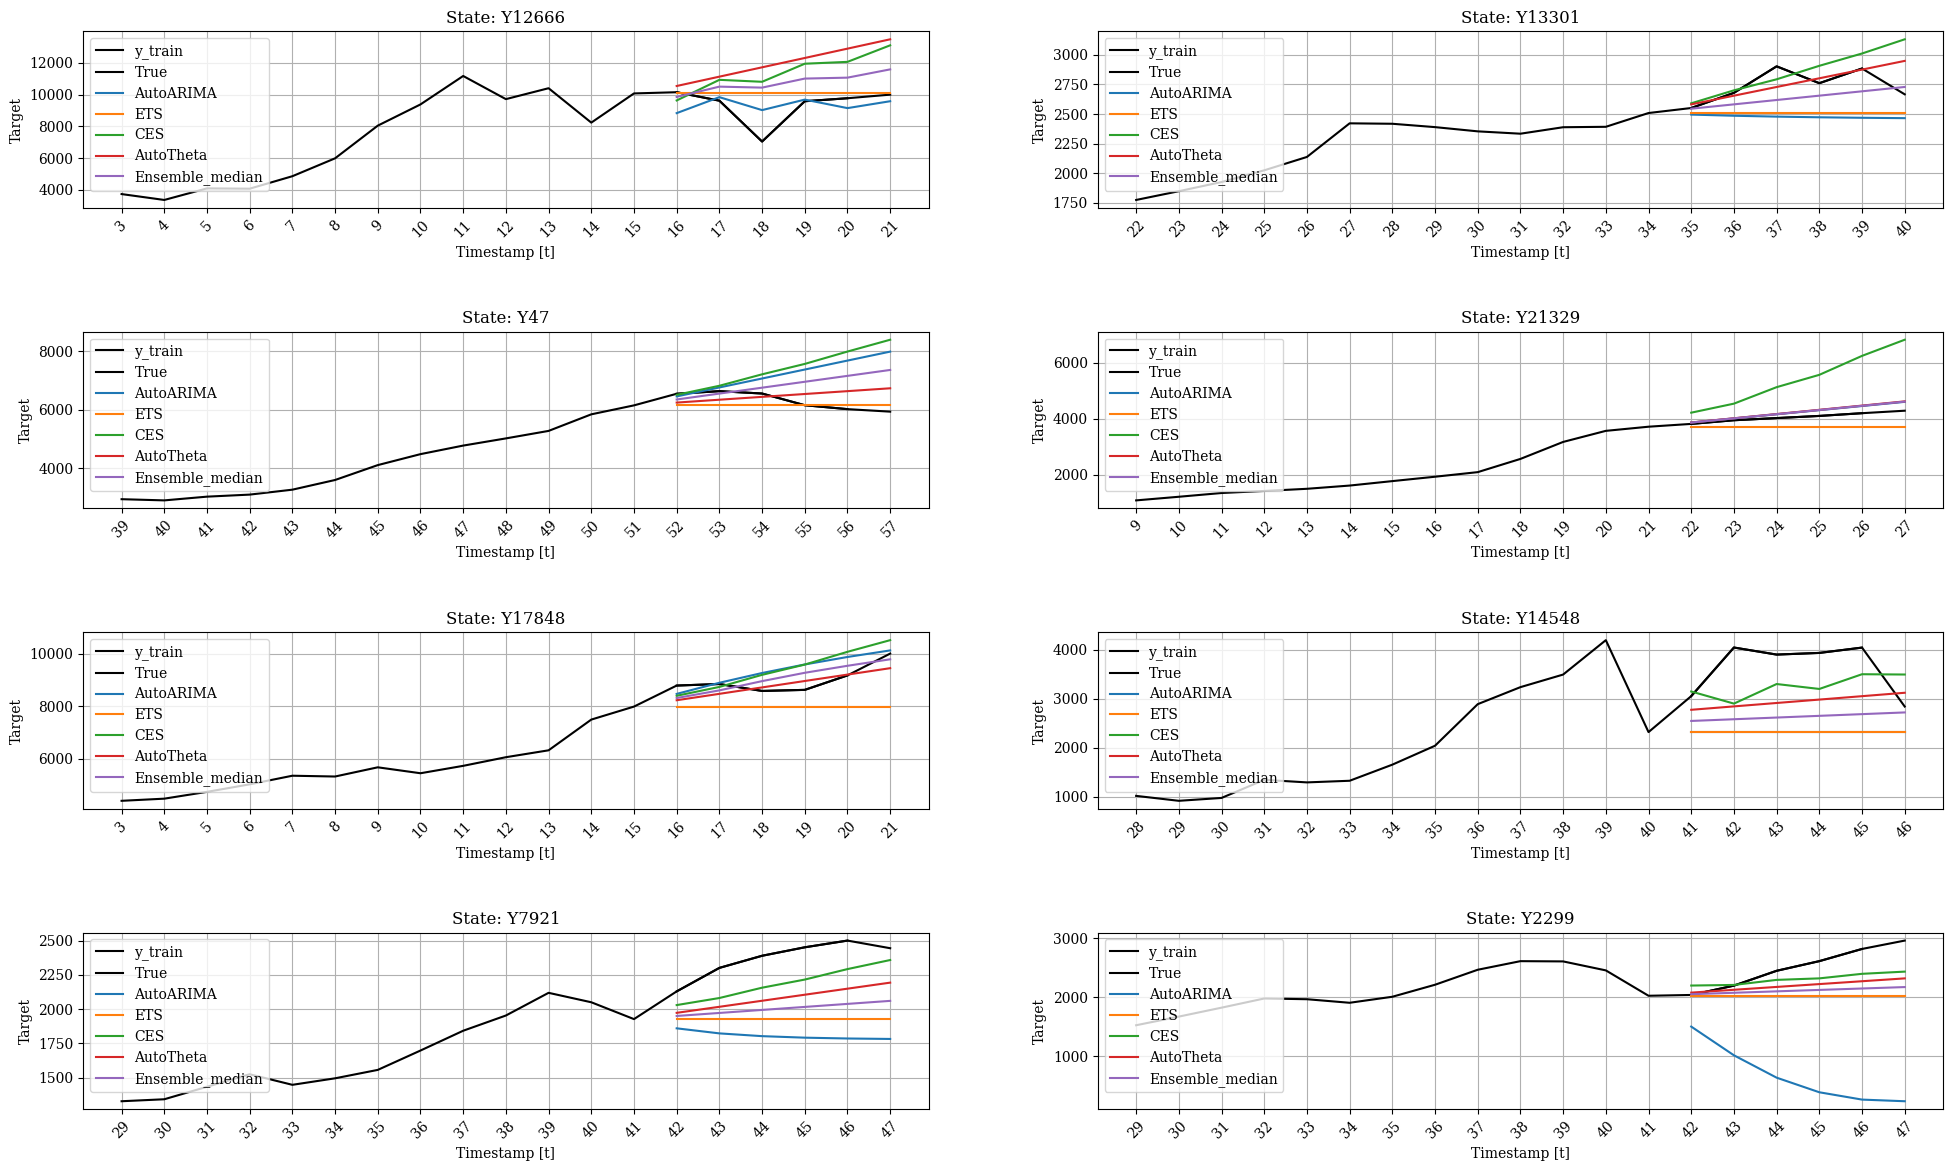

In [58]:
# Get trarin dataframe:
df_train_yearly = get_train_df('Yearly')

# Plot a random sample of 8 series:
plot_grid(df_train_yearly.groupby('unique_id').tail(3*6), 
          model_cols=['AutoARIMA', 'ETS', 'CES', 'AutoTheta', 'Ensemble_median'], 
          df_test=yearly_df_forecast)

In [20]:
#Evaluate models metrics:
df_fore_hformat_yearly = pd.read_csv('yearly_df_forecast.csv')

df_fore_hformat_yearly = df_fore_hformat_yearly.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_yearly['ds'] = df_fore_hformat_yearly.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_yearly: np.arange(1, len(df_fore_hformat_yearly) + 1))
df_fore_hformat_yearly = pd.melt(df_fore_hformat_yearly, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_yearly = pd.pivot(df_fore_hformat_yearly, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_yearly['model'] == 'Ensemble_median'
df_fore_hformat_yearly_ens = df_fore_hformat_yearly[df_mask]

df_fore_hformat_yearly_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_yearly_ens = df_fore_hformat_yearly_ens.set_index(df_fore_hformat_yearly_ens['id'])
df_fore_hformat_yearly_ens = df_fore_hformat_yearly_ens.drop(['id', 'model'], axis=1)

y_metrics_ens = M4Evaluation.evaluate('data2', 'Yearly', df_fore_hformat_yearly_ens.sort_values('id').values)

#AutoARIMA
df_mask=df_fore_hformat_yearly['model'] == 'AutoARIMA'
df_fore_hformat_yearly_AutoARIMA = df_fore_hformat_yearly[df_mask]

df_fore_hformat_yearly_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_yearly_AutoARIMA = df_fore_hformat_yearly_AutoARIMA.set_index(df_fore_hformat_yearly_AutoARIMA['id'])
df_fore_hformat_yearly_AutoARIMA = df_fore_hformat_yearly_AutoARIMA.drop(['id', 'model'], axis=1)

y_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Yearly', df_fore_hformat_yearly_AutoARIMA.sort_values('id').values)

#ETS
df_mask=df_fore_hformat_yearly['model'] == 'ETS'
df_fore_hformat_yearly_ETS = df_fore_hformat_yearly[df_mask]

df_fore_hformat_yearly_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_yearly_ETS = df_fore_hformat_yearly_ETS.set_index(df_fore_hformat_yearly_ETS['id'])
df_fore_hformat_yearly_ETS = df_fore_hformat_yearly_ETS.drop(['id', 'model'], axis=1)

y_metrics_ETS = M4Evaluation.evaluate('data2', 'Yearly', df_fore_hformat_yearly_ETS.sort_values('id').values)

#CES
df_mask=df_fore_hformat_yearly['model'] == 'CES'
df_fore_hformat_yearly_CES = df_fore_hformat_yearly[df_mask]

df_fore_hformat_yearly_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_yearly_CES = df_fore_hformat_yearly_CES.set_index(df_fore_hformat_yearly_CES['id'])
df_fore_hformat_yearly_CES = df_fore_hformat_yearly_CES.drop(['id', 'model'], axis=1)

y_metrics_CES = M4Evaluation.evaluate('data2', 'Yearly', df_fore_hformat_yearly_CES.sort_values('id').values)

#AutoTheta
df_mask=df_fore_hformat_yearly['model'] == 'AutoTheta'
df_fore_hformat_yearly_AutoTheta = df_fore_hformat_yearly[df_mask]

df_fore_hformat_yearly_AutoTheta.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_yearly_AutoTheta = df_fore_hformat_yearly_AutoTheta.set_index(df_fore_hformat_yearly_AutoTheta['id'])
df_fore_hformat_yearly_AutoTheta = df_fore_hformat_yearly_AutoTheta.drop(['id', 'model'], axis=1)

y_metrics_AutoTheta = M4Evaluation.evaluate('data2', 'Yearly', df_fore_hformat_yearly_AutoTheta.sort_values('id').values)

# Total metrics:
metrics_yearly = [y_metrics_ens, y_metrics_AutoARIMA, y_metrics_ETS, y_metrics_CES, y_metrics_AutoTheta]  # List of dataframes
total_metrics_yearly = pd.concat(metrics_yearly)
total_metrics_yearly['model'] = ['Ensemble', 'AutoARIMA', 'ETS', 'CES', 'AutoTheta']
total_metrics_yearly

,SMAPE,MASE,OWA,model
Yearly,13.616380,3.061464,0.801754,Ensemble
Yearly,16.568475,3.832562,0.989085,AutoARIMA
Yearly,16.342174,3.974360,1.000000,ETS
Yearly,14.460315,3.416768,0.872275,CES
Yearly,14.019304,3.093811,0.818151,AutoTheta


### Overall  metrics:

In [59]:
metrics_all_models = [total_metrics_hourly, 
                                total_metrics_daily, 
                                total_metrics_weekly, 
                                total_metrics_monthly, 
                                total_metrics_quarterly,
                                total_metrics_yearly]  # List of dataframes
total_metrics_all_models = pd.concat(metrics_all_models)

total_metrics_all_models.reset_index(inplace=True, names='frequency')
total_metrics_all_models.set_index(total_metrics_all_models['model'], inplace=True)
total_metrics_all_models.drop(columns='model', inplace=True)

total_metrics_all_models.sort_index()

,frequency,SMAPE,MASE,OWA
model,,,,
AutoARIMA,Hourly,13.785071,1.060768,0.596394
AutoARIMA,Yearly,16.568475,3.832562,0.989085
AutoARIMA,Quarterly,11.565041,1.398230,1.034920
AutoARIMA,Daily,3.147886,3.313655,1.022225
AutoARIMA,Monthly,14.571859,1.083398,1.014449
AutoARIMA,Weekly,7.918108,2.674030,0.913559
AutoTheta,Weekly,9.183420,2.608353,0.970793
AutoTheta,Quarterly,10.244733,1.182911,0.896465
AutoTheta,Monthly,13.212794,0.962291,0.910401


### Conclusions

The Ensemble model created in a few lines of code outperform almost all the metrics of AutoARIMA, ETS and CES forecasts by separeted. 

In [60]:
conditions = [
    (total_metrics_all_models['frequency'] == 'Hourly'),
    (total_metrics_all_models['frequency'] == 'Daily'),
    (total_metrics_all_models['frequency'] == 'Weekly'),
    (total_metrics_all_models['frequency'] == 'Monthly'),
    (total_metrics_all_models['frequency'] == 'Quarterly'),
    (total_metrics_all_models['frequency'] == 'Yearly')
]

weights = [0.00414, 0.04227, 0.00359, 0.48, 0.24, 0.23]

total_metrics_all_models['weights'] = np.select(conditions, weights)
total_metrics_all_models['smape_weighted'] = total_metrics_all_models['SMAPE'] * total_metrics_all_models['weights'] 
total_metrics_all_models['mase_weighted'] = total_metrics_all_models['MASE'] * total_metrics_all_models['weights']
total_metrics_all_models['owa_weighted'] = total_metrics_all_models['OWA'] * total_metrics_all_models['weights']

total_metrics_all_models.groupby('model')[['smape_weighted', 'mase_weighted', 'owa_weighted']].sum()


,smape_weighted,mase_weighted,owa_weighted
model,,,
AutoARIMA,13.799409,1.891155,1.011764
AutoTheta,12.262413,1.614479,0.890125
CES,12.388720,1.672762,0.897565
ETS,12.874474,1.807509,0.931799
Ensemble,11.742852,1.563174,0.853163


As we can see in the following table, StatsForecast Ensemble Model, StatsForecast CES, StatsForecast StatsForecast ETS, StatsForecast AutoARIMA and StatsForecast AutoTheta can achive high performance metrics, ranking in the top positions of the M4 competition with lower complexity compared with others models.

<img src="https://github.com/Nixtla/statsforecast/blob/Developments/Developments/Ensemble%20model/Assets/m4_ranking.jpg?raw=true" width="500" height="650" />